In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re 
import holidays 
from dfply import *
from IPython.display import display
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate
%matplotlib inline

#### Assignment 1

In [2]:
def get_NERC_calendar(y):
    # get nerc dates for a year 

    # create a NERC Holiday calendar 
    NERC = ["New Year's Day", 'Memorial Day', 'Independence Day', 'Labor Day', 'Thanksgiving', 'Christmas Day']
    custom_holidays = holidays.HolidayBase()
    for key, val in holidays.UnitedStates(years = y).items():
        if val in NERC:
            custom_holidays.append({key: val})
    return custom_holidays

get_NERC_calendar(2018)

{datetime.date(2018, 1, 1): "New Year's Day",
 datetime.date(2018, 5, 28): 'Memorial Day',
 datetime.date(2018, 7, 4): 'Independence Day',
 datetime.date(2018, 9, 3): 'Labor Day',
 datetime.date(2018, 11, 22): 'Thanksgiving',
 datetime.date(2018, 12, 25): 'Christmas Day'}

In [3]:
def isDSTStartDate(date):
    # identify if the date is second Sunday in March
    weekday_index = date.weekday()
    year, month, day = date.year, date.month, date.day
    first_weekday_monthly = datetime(year, month,1).weekday()
    expected_weekday_second_sunday = 7 - (1 + first_weekday_monthly) + 7 + 1
    
    if weekday_index == 6 and month == 3 and day == expected_weekday_second_sunday:
        return True
    return False 

print(isDSTStartDate(datetime(2020,3,8)))
print(isDSTStartDate(datetime(2020,3,7)))

True
False


In [4]:
def isDSTEndDate(date):
    # identify if the date is first Sunday in November
    weekday_index = date.weekday()
    year, month, day = date.year, date.month, date.day
    first_weekday_monthly = datetime(year, month,1).weekday()
    expected_weekday_second_sunday = 7 - (1 + first_weekday_monthly) + 1
    
    if weekday_index == 6 and month == 11 and day == expected_weekday_second_sunday:
        return True
    return False 

print(isDSTEndDate(datetime(2020,11,1)))
print(isDSTEndDate(datetime(2020,11,2)))

True
False


In [5]:
def get_onpeak_hour(date, area='eastern'):
    # get onpeak type num of hours in a single day 
    weekday_index = date.weekday()
    y = date.year
    nerc_holiday = get_NERC_calendar(y)
    
    if area == 'eastern':
        if weekday_index in range(0,5) and nerc_holiday.get(date) == None:     
            return 16    # from HE7 to HE22

    elif area == 'western': 
        if weekday_index in range(0,6) and nerc_holiday.get(date) == None:  # western mkt takes Saturday as a weekday
            return 16 
    
    return 0 

print(datetime(2018,1,13).weekday(),   holidays.UnitedStates(years = 2018).get(datetime(2018,1,13)))
print(get_onpeak_hour(datetime(2018,1,1), ))     # new year 
print(get_onpeak_hour(datetime(2018,1,13), 'eastern'))
print(get_onpeak_hour(datetime(2018,1,13), 'western'))

5 None
0
0
16


In [6]:
def get_2x16H_hour(date, area='eastern'):
    # get 2x16H type num of hours in a single day 
    weekday_index = date.weekday()
    y = date.year
    nerc_holiday = get_NERC_calendar(y)
    
    if area == 'eastern':
        if weekday_index not in range(0,5) and nerc_holiday.get(date) != None:     
            return 16    # from HE7 to HE22

    elif area == 'western': 
        if weekday_index not in range(0,6) and nerc_holiday.get(date) != None:  # western mkt takes Saturday as a weekday
            return 16 
    
    return 0 

print(get_2x16H_hour(datetime(2018,1,1), ))

0


In [7]:
def get_period_type(period):
    # identify period type
    # assume year is 4-digit 
    
    this_year = datetime.now().year
    next_year = this_year + 1
    ptype = None 
    try:
        if len(period.split('-')) == 3:
            y, m, d = period.split('-')
            y, m, d = int(y), int(m), int(d)
            if (y in range(1, next_year)) and (m in range(1,13)) and (d in range(1, 32)):
                ptype = 'daily'
                
        else:
            months = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            if period[4:] in months and int(period[:4]) in range(1,next_year):
                ptype = 'monthly'
            elif period[-1] == 'A' and int(period[:-1]) in range(1,next_year):
                ptype = 'annually'
            elif int(period[-1]) in range(1,5) and period[-2] == 'Q' and int(period[:-2] ) in range(1,next_year):
                ptype = 'quarterly'
        return ptype
    except:
        print('period type error')
        return None  
    
print(get_period_type("2018-2-3"))
print(get_period_type("2018Mar"))
print(get_period_type("2018Q2"))
print(get_period_type("2018A"))

daily
monthly
quarterly
annually


In [8]:
def get_start_end(period):
    # return the start and end dates, given any kind of period 
    
    period_type = get_period_type(period)
    try:
        if period_type == 'daily':
            start_date = datetime.strptime(period, '%Y-%m-%d')
            end_date = start_date
        else:
            months = ['Jan', 'Feb', 'Mar', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
            year = period[:4]
            
            if period_type == 'monthly':
                month = months.index(period[4:]) + 1
                start_str = year + "-" + str(month) + '-1'
                if month == 12:
                    year = str(int(year) + 1)
                    next_month = 1
                else:
                    next_month = month + 1
                end_str = year + "-" + str(next_month) + '-1'    

            elif period_type == 'quarterly':
                quarter_num = int(period[-1])
                if quarter_num == 1:
                    start_month = months.index('Jan') + 1
                    end_month = months.index('Mar') + 1
                elif quarter_num == 2:
                    start_month = months.index('April') + 1
                    end_month = months.index('June') + 1
                elif quarter_num == 3:
                    start_month = months.index('July') + 1
                    end_month = months.index('Sep') + 1
                elif quarter_num == 4:
                    start_month = months.index('Oct') + 1
                    end_month = months.index('Dec') + 1

                start_str = year + "-" + str(start_month) + '-1'
                if end_month == 12:    
                    next_end_month = 1
                    year = str(int(year) + 1)
                else:
                    next_end_month = end_month + 1
                end_str = year + "-" + str(next_end_month) + '-1'    

            elif period_type == 'annually':
                start_month = months.index('Jan') + 1
                start_str = year + "-" + str(start_month) + '-1'
                year = str(int(year) + 1)
                end_str = year + '-1' + '-1'  

            date_range = pd.date_range(start = start_str, end = end_str )[:-1]
            start_date = date_range[0]
            end_date = date_range[-1]   
         
        return start_date, end_date 
    except:
        print('cannot get start and end dates')
        return None, None 
    
print(get_start_end("2019-12-5"))
print(get_start_end("2019Feb"))
print(get_start_end("2018Q4"))
print(get_start_end("2018A"))
print(get_start_end("2018C"))   # counterexample

(datetime.datetime(2019, 12, 5, 0, 0), datetime.datetime(2019, 12, 5, 0, 0))
(Timestamp('2019-02-01 00:00:00', freq='D'), Timestamp('2019-02-28 00:00:00', freq='D'))
(Timestamp('2018-10-01 00:00:00', freq='D'), Timestamp('2018-12-31 00:00:00', freq='D'))
(Timestamp('2018-01-01 00:00:00', freq='D'), Timestamp('2018-12-31 00:00:00', freq='D'))
period type error
cannot get start and end dates
(None, None)


In [9]:
def get_hours(iso, peak_type, period):
    """
    iso (character): one of PJM/MISO/ERCOT/SPP/NYISO/WECC/CAISO (see item 1 below)
       - PJMISO, MISO, ERCOT, SPPISO, NYISO are eastern
       - WECC and CAISO is western
    peak_type (character): one of onpeak/offpeak/flat/2x16H/7x8
    period (character): has 4 types: “2018-2-3” as a daily, “2018Mar” as a monthly, “2018Q2” as a quarterly, “2018A” as an annually.
    
    """
    if iso not in ['PJMISO', 'MISO', 'ERCOT', 'SPPISO', 'NYISO', 'WECC' , 'CAISO']:
        print('cannot find the iso')
        return [None]*5
    if peak_type not in ['onpeak', 'offpeak', 'flat', '2x16H', '7x8']:
        print('cannot find the peak type')
        return [None]*5
    
    start_date, end_date = get_start_end(period)
    if start_date == None and end_date == None:   # if the period char contains any error 
        hours = 0 
        return [None]*5
    date_range = pd.date_range(start=start_date, end=end_date)
    
    
    if iso in ['PJMISO', 'MISO', 'ERCOT', 'SPPISO', 'NYISO']:  
        area_flag = 'eastern'
    elif iso in [ 'WECC' , 'CAISO']:
        area_flag = 'western'

    # adjust for daylight saving time 
    # WIKI: In the U.S., daylight saving time starts on the second Sunday in March and ends on the first Sunday in November, 
    # with the time changes taking place at 2:00 a.m. local time.    
    DST_start_adj = - sum([isDSTStartDate(date) for date in date_range])
    DST_end_adj = sum([isDSTEndDate(date) for date in date_range])
    
    
    if peak_type in ['onpeak', 'offpeak']:
        onpeak_hours = 0
        for date in date_range:
            onpeak_hours += get_onpeak_hour(date, area_flag)
        if peak_type == 'onpeak':
            hours = onpeak_hours    # HE7 to HE22 not affected by DST  
        elif peak_type == 'offpeak':
            if iso != 'MISO':
                hours = 24 * date_range.shape[0]  - onpeak_hours + DST_start_adj + DST_end_adj
            else: 
                hours = 24 * date_range.shape[0]  - onpeak_hours   # MISO does not have the daylight-saving setting
    elif peak_type == 'flat':
        if iso != 'MISO':
            hours = 24 * date_range.shape[0] + DST_start_adj + DST_end_adj   
        else:
            hours = 24 * date_range.shape[0] 
    elif peak_type == '2x16H':
        hours = 0
        for date in date_range:
            hours += get_2x16H_hour(date, area_flag)   # not affected by DST  
    elif peak_type == '7x8':
        if iso != 'MISO':
            hours =  (24-16) * date_range.shape[0] + DST_start_adj + DST_end_adj   
        else:
            hours = (24-16) * date_range.shape[0] 
    
    return iso, peak_type, start_date, end_date, hours 


print(get_hours('PJMISO', 'offpeak', '2020Mar'))
print(get_hours('MISO', 'offpeak', '2020Mar'))
print(get_hours('CAISO', 'onpeak', '2020Oct'))
# Counterexamples 
print('\n')
print(get_hours('CAI', 'onpeak', '2020Oct'))   # iso error 
print(get_hours('CAISO', 'peak', '2020Oct'))   # peak type error
print(get_hours('CAISO', 'onpeak', '2020ABC'))   # period time error 

('PJMISO', 'offpeak', Timestamp('2020-03-01 00:00:00', freq='D'), Timestamp('2020-03-31 00:00:00', freq='D'), 391)
('MISO', 'offpeak', Timestamp('2020-03-01 00:00:00', freq='D'), Timestamp('2020-03-31 00:00:00', freq='D'), 392)
('CAISO', 'onpeak', Timestamp('2020-10-01 00:00:00', freq='D'), Timestamp('2020-10-31 00:00:00', freq='D'), 432)


cannot find the iso
[None, None, None, None, None]
cannot find the peak type
[None, None, None, None, None]
period type error
cannot get start and end dates
[None, None, None, None, None]


#### Assignment 2: Meter Data formatting

In [10]:
def load_df(path, index_col=None, ):
    with open(path, 'r') as f:
        df = pd.read_csv(f, index_col=index_col, encoding='utf-8')
    return df

In [11]:
# Helper functions 
@dfpipe
def to_datetime(df, time_col):
    return pd.to_datetime(df[time_col])

@dfpipe
def get_year(df, time_col):
    # assume input is datetime.datetime format 
    f = lambda x: x.year
    return df[time_col].apply(f)

@dfpipe
def get_datehour(df, time_col, year=2013):
    def f(dt):
        month, day, hour = dt.month, dt.day, dt.hour 
        return datetime(year, month, day, hour, 0, 0)
    return df[time_col].apply(f)

@dfpipe
def str_to_datetime(df, time_col, year=2013):
    # the ""m/d hh:mm:ss" format is special and cannot be directly transformed to datetime 
    # another issue is the datetime string uses "24:00:00" instead of "00:00:00" that ppl usually use 
    def f(x):
        date, time = x.split()
        m, d = date.split('/')
        h = time.split(':')[0]
        m, d, h = int(m), int(d), int(h)
        if h==24: 
            h = 0
            x_next = datetime(year, m, d) + timedelta(days=1)
            m, d = x_next.month, x_next.day 
            m, d = int(m), int(d)
        return datetime(year, m, d, h, 0, 0)
    return df[time_col].apply(f)

@dfpipe
def get_sum_Elec(df, Elec_cols):
    return df[Elec_cols].sum(axis = 1)

@dfpipe
def get_weekday(df, time_col):
    def f(x):
        if x.weekday() in range(0, 5):
            return x.date()
        else:
            return None 
    return df[time_col].apply(f)

@dfpipe
def get_month(df, time_col):
    def f(x):
            return str(x.year) + str(x.month).zfill(2)  
    return df[time_col].apply(f)

In [12]:

def merge_and_output(file_path_new, file_path_base, time_col_new, time_col_base, file_path_ouput):
    """
    Work on the extra data file 
    """
    df_new = load_df(file_path_new, index_col=0)
  
    # turn watt to kwatt 
    df_new >>= mutate(W_min_kW = X.W_min / 1000)
    # transform the time str to datetime.datetime
    dateTime = df_new >> to_datetime(time_col_new)
    df_new >>= mutate(dateTime = dateTime)
    dateHour = df_new >> get_datehour("dateTime")
    df_new >>= mutate(dateHour = dateHour)

    # aggregate minute data to hourly 
    df_new_hourly = df_new >> group_by(X.dateHour) >> summarize(W_min_kW_hourly_Electricity = X.W_min_kW.sum(),)
    
    """
    Work on the baseline data file and merge files 
    """
    df_base = load_df(file_path_base, )
    
    # get rid of gas / other energy consumptions 
    df_base >>= select(time_col_base, contains('Electricity'))
    # transform the time str to datetime.datetime 
    dateHour = df_base >> str_to_datetime( time_col_base)   
    df_base >>= mutate(dateHour = dateHour) >> drop(time_col_base)
    
    # Merge data 
    df_joined = df_base >> inner_join(df_new_hourly, by = "dateHour")    #  overlap period; dateHour is defined within this function 
    df_joined_Elec = df_joined >> drop("dateHour")    
    
    # sum up overall electricity consumption 
    total_hourly_Elec = df_joined_Elec >> get_sum_Elec( df_joined_Elec.columns )
    df_output = df_joined >> mutate(total_hourly_Electricity = total_hourly_Elec)


    df_output.to_csv(file_path_output)
    return df_output


# Implement the merge 
time_col_new = "time"
file_path_new = "data/Assignment 2 - new.app4.csv"
time_col_base = "Date/Time"
file_path_base = "data/Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv"
file_path_output = 'data/Assignment 2 - Output.csv'
df_output = merge_and_output(file_path_new, file_path_base, time_col_new, time_col_base, file_path_output)
df_output.head()

,Electricity:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),dateHour,W_min_kW_hourly_Electricity,total_hourly_Electricity
0,1.479426,0.0,0.347519,0.100007,0.447526,0.100007,0.047163,0.010160,0.360615,0.272322,0.324996,2013-06-07 11:00:00,57.388943,60.878684
1,1.559733,0.0,0.454263,0.130764,0.585027,0.130764,0.047163,0.010160,0.350008,0.267735,0.282996,2013-06-07 12:00:00,27.227961,31.046575
2,1.702835,0.0,0.603876,0.169912,0.773789,0.169912,0.047163,0.010160,0.319024,0.276993,0.259063,2013-06-07 13:00:00,111.476298,115.809026
3,1.859094,0.0,0.752179,0.211629,0.963808,0.211629,0.047163,0.010160,0.294229,0.292590,0.234500,2013-06-07 14:00:00,109.021960,113.898942
4,2.100629,0.0,0.921579,0.253177,1.174756,0.253177,0.050307,0.010837,0.301026,0.308854,0.238204,2013-06-07 15:00:00,5.773963,11.386511


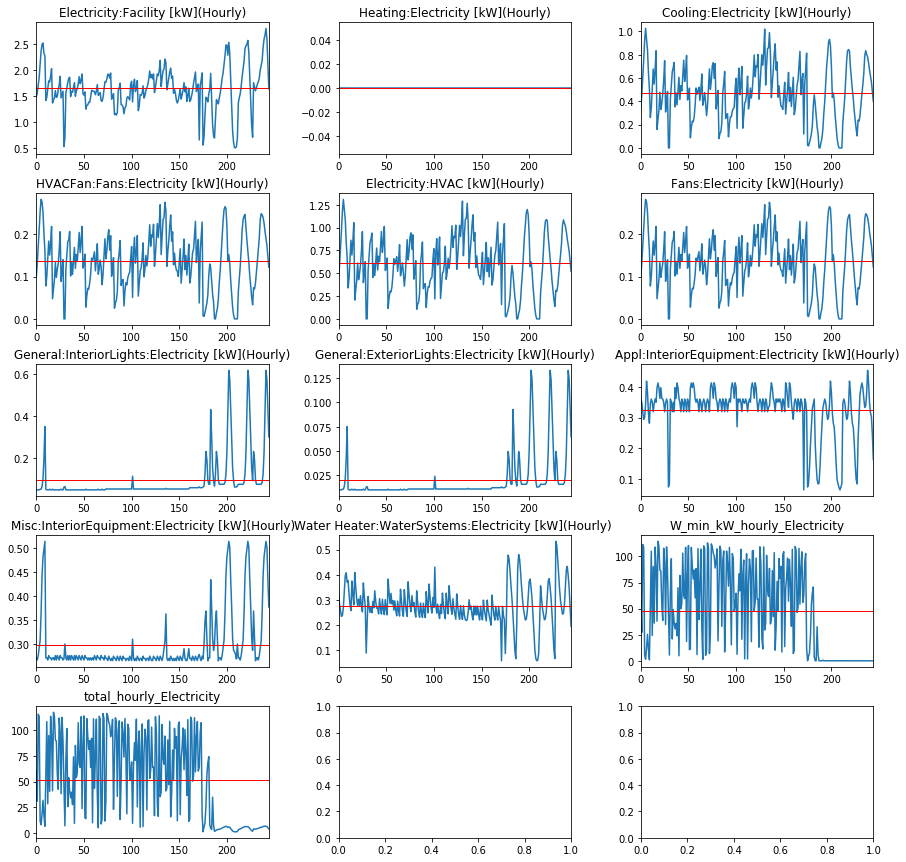

In [13]:
# Below are all Plotting 
import matplotlib.pyplot as plt
df_output = load_df(file_path_output, index_col=0)
df_output['dateHour'] = pd.to_datetime(df_output.dateHour)


# by hour 
df_output_copy = df_output.drop('dateHour', axis=1)
fig, axes = plt.subplots(5,3, figsize=(15, 15), )
plt.subplots_adjust(hspace= .3, wspace=.3)

for i in range(len(axes)):
    for j in range(len(axes[0])):
        try:
            col = df_output_copy.columns[3*i + j]
            df_output_copy[col].plot(title = col, ax=axes[i][j])
            axes[i][j].axhline( df_output_copy[col].mean(), color='r', lw=1 )
        except:
            pass
plt.show()  
fig.savefig('plots/Assignment 2 - hourly.jpg')

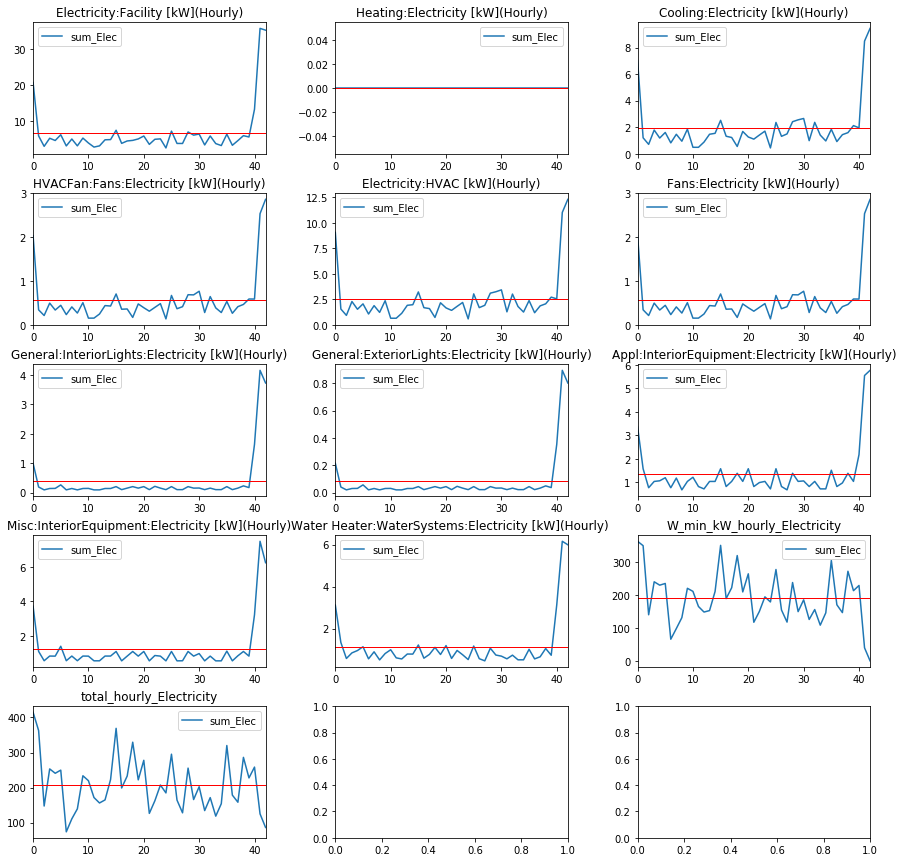

In [14]:
# by weekday 

fig, axes = plt.subplots(5,3, figsize=(15, 15), )
plt.subplots_adjust(hspace= .3, wspace=.3)

weekday = df_output >> get_weekday("dateHour")
df_output_weekday = df_output >> mutate(weekday = weekday) >> drop("dateHour")

for i in range(len(axes)):
    for j in range(len(axes[0])):
        try:
            col = df_output_copy.columns[3*i + j]
            data = df_output_weekday >> select("weekday", col) >> group_by("weekday") >> summarize(sum_Elec = X[col].sum()) >> select(X.sum_Elec)
            
            data.plot(title = col, ax=axes[i][j])
            axes[i][j].axhline( data.mean().values[0], color='r', lw=1 )
        except:
            pass
       
plt.show()  
fig.savefig('plots/Assignment 2 - weekday.jpg')



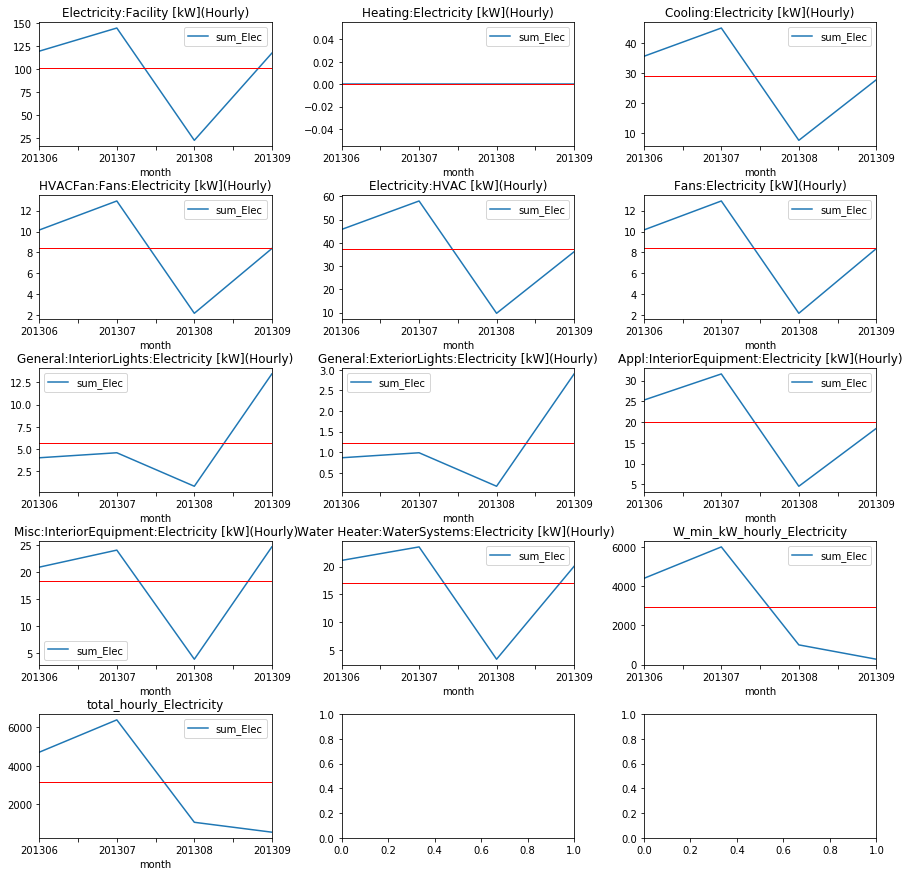

In [15]:
# by month
month = df_output >> get_month("dateHour")
df_output_month = df_output >> mutate(month = month) >> drop("dateHour")

fig, axes = plt.subplots(5,3, figsize=(15, 15), )
plt.subplots_adjust(hspace= .4, wspace=.3)


for i in range(len(axes)):
    for j in range(len(axes[0])):
        try:
            col = df_output_copy.columns[3*i + j]
            data = (df_output_month >> select("month", col) >> group_by("month") >> summarize(sum_Elec = X[col].sum())).set_index("month")
            
            data.plot(title = col, ax=axes[i][j])
            axes[i][j].axhline( data.mean().values[0], color='r', lw=1 )
        except:
            pass
       
plt.show()  
fig.savefig('plots/Assignment 2 - monthly.jpg')


#### Assignment 3: EDA and forecast model

In [16]:
file_path = "data/Assignment 3 - timeseries_data.xlsx"
df = pd.read_excel(file_path, )   
df.DATETIME = pd.to_datetime(df.DATETIME)
df.set_index('DATETIME', inplace=True, drop=True)
df.sort_index(inplace=True)

# print(df.columns)

df.columns = ['RTLMP', 'WIND',
       'SOLAR', 'RTLOAD', 'HOURENDING',
       'MARKETDAY', 'PEAKTYPE', 'MONTH', 'YEAR']
df.head()

,RTLMP,WIND,SOLAR,RTLOAD,HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
DATETIME,,,,,,,,,
2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355,1,2017-01-01,OFFPEAK,JANUARY,2017
2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913,2,2017-01-01,OFFPEAK,JANUARY,2017
2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175,3,2017-01-01,OFFPEAK,JANUARY,2017
2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513,4,2017-01-01,OFFPEAK,JANUARY,2017
2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413,5,2017-01-01,OFFPEAK,JANUARY,2017


1. EDA

In [17]:
print(df.shape)
df_min_max = pd.DataFrame(index = df.columns[:-3], columns = ['min', 'max'])
for col in df.columns[:-3]:
    df_min_max.loc[col, 'min'] = df[col].min()
    df_min_max.loc[col, 'max'] = df[col].max()
display(df_min_max)    

(14987, 9)


,min,max
RTLMP,-17.86,2809.36
WIND,54.44,20350.4
SOLAR,0,1257.54
RTLOAD,25566.5,73264.7
HOURENDING,1,24
MARKETDAY,2017-01-01 00:00:00,2018-09-17 00:00:00


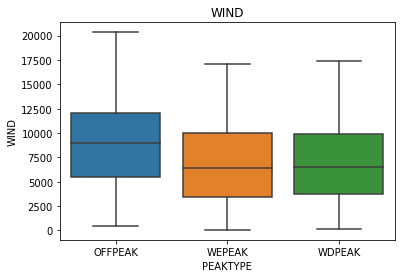

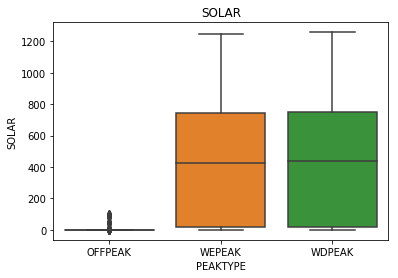

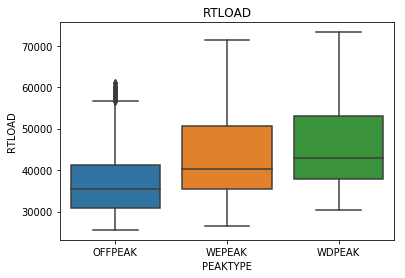

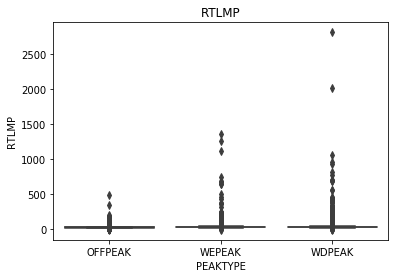

In [18]:
# distribution by PEAKTYPE shown by boxplot 
sns.boxplot(x='PEAKTYPE', y='WIND', data=df).set_title('WIND'); plt.show();
sns.boxplot(x='PEAKTYPE', y='SOLAR', data=df).set_title('SOLAR'); plt.show()
sns.boxplot(x='PEAKTYPE', y='RTLOAD', data=df).set_title('RTLOAD'); plt.show()
sns.boxplot(x='PEAKTYPE', y='RTLMP', data=df).set_title('RTLMP'); plt.show()

In [19]:
# # distribution 
# print("PEAKTYPE: ", df.PEAKTYPE.unique())
# def get_stats(col_name):
#     df_group_y = pd.DataFrame(columns=['mean', 'std', 'min', '25%', 'median', '75%', 'max', 'cnt' ], index=df.PEAKTYPE.unique())
#     group_y = df[[col_name, 'PEAKTYPE']].groupby('PEAKTYPE')
#     df_group_y['mean'] = group_y.mean()
#     df_group_y['std'] = group_y.std()
#     df_group_y['min'] = group_y.min()
#     df_group_y['25%'] = group_y.quantile(0.25)
#     df_group_y['median'] = group_y.median()
#     df_group_y['75%'] = group_y.quantile(0.75)
#     df_group_y['max'] = group_y.max()
#     df_group_y['cnt'] = group_y.count()
#     return df_group_y

# display('RTLMP:', get_stats('RTLMP'))
# display('WIND:', get_stats('WIND'))
# display('SOLAR:', get_stats('SOLAR'))
# display('RTLOAD:', get_stats('RTLOAD'))

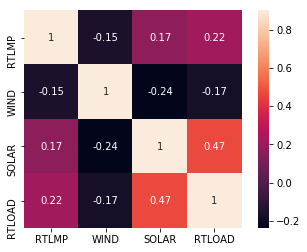

c:\program files (x86)\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Chen Yunfei\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Chen Yunfei\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


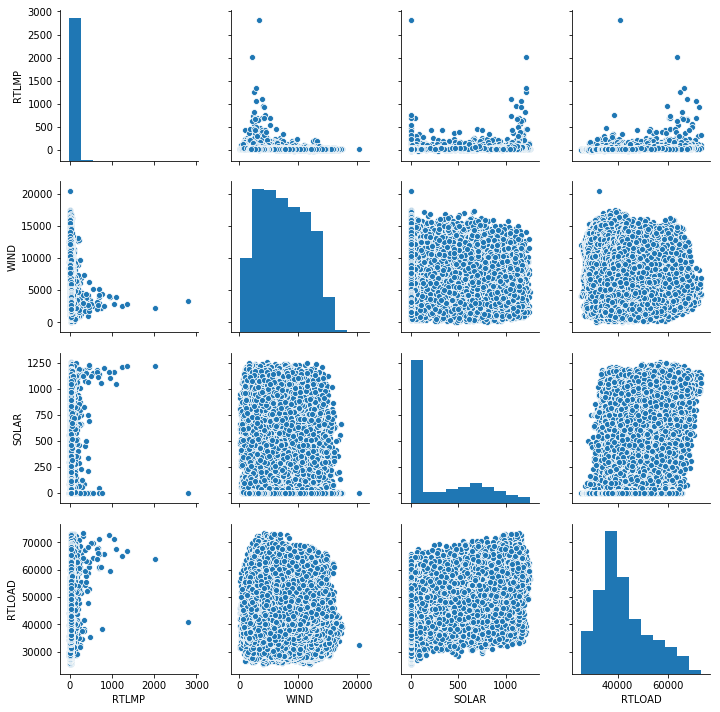

In [20]:
# correlation
temp = df[['RTLMP', 'WIND', 'SOLAR', 'RTLOAD']].copy()
df_corr = temp.corr()

# correlation with lag = 1 
temp['RTLMP'] = temp['RTLMP'].shift(-1)
df_corr_lag1 = temp.corr()

# display(df_corr, df_corr_lag1)
sns.heatmap(df_corr_lag1, vmax=0.9, square=True, annot=True); plt.show()
sns.pairplot(temp, size = 2.5); plt.show()

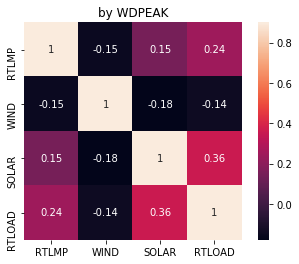

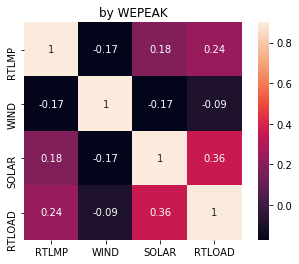

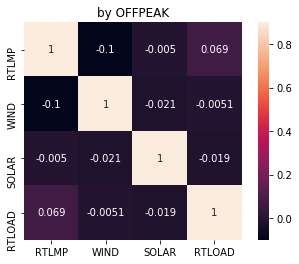

In [21]:
# lag=1 correlation by peak type
temp = pd.concat([temp, df['PEAKTYPE']], axis=1)

df_corr_lag1_wdpeak = temp[temp['PEAKTYPE'] == 'WDPEAK'].corr()
df_corr_lag1_wepeak = temp[temp['PEAKTYPE'] == 'WEPEAK'].corr()
df_corr_lag1_offpeak = temp[temp['PEAKTYPE'] == 'OFFPEAK'].corr()
# display(df_corr_lag1_wdpeak, df_corr_lag1_wepeak, df_corr_lag1_offpeak)
sns.heatmap(df_corr_lag1_wdpeak, vmax=0.9, square=True, annot=True).set_title('by WDPEAK'); plt.show()
sns.heatmap(df_corr_lag1_wepeak, vmax=0.9, square=True, annot=True).set_title('by WEPEAK'); plt.show()
sns.heatmap(df_corr_lag1_offpeak, vmax=0.9, square=True, annot=True).set_title('by OFFPEAK'); plt.show()

- no correlation > 0.7, sign of adsence of multicollinearity

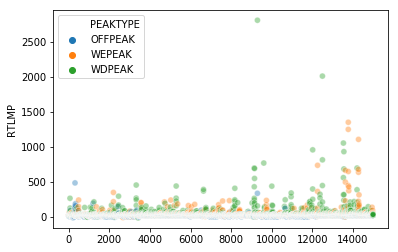

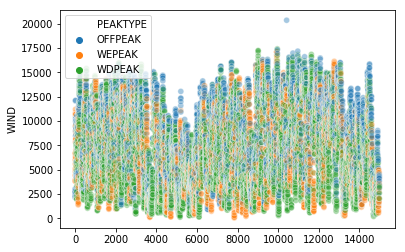

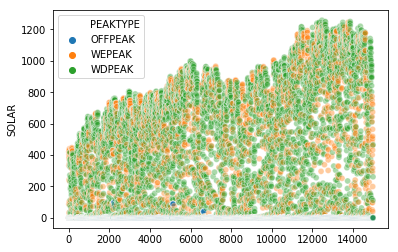

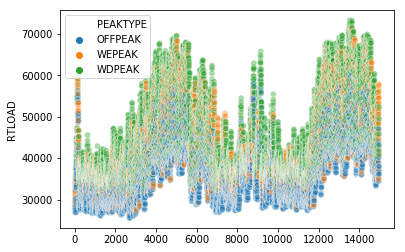

In [22]:
# scatter plotting
df_plot = df[['RTLMP', 'WIND', 'SOLAR', 'RTLOAD', 'PEAKTYPE']]

for col in ['RTLMP', 'WIND', 'SOLAR', 'RTLOAD']:
    sns.scatterplot(data=df_plot, x=np.arange(df_plot.shape[0]), y=col, hue="PEAKTYPE", alpha=.4)
    plt.show()

c:\program files (x86)\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files (x86)\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
c:\program files (x86)\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,RTLMP,RTLMP lag1,RTLMP lag2,RTLMP lag3
RTLMP,1.000000,0.499032,0.235322,0.112398
RTLMP lag1,0.499032,1.000000,0.499032,0.235321
RTLMP lag2,0.235322,0.499032,1.000000,0.499032
RTLMP lag3,0.112398,0.235321,0.499032,1.000000


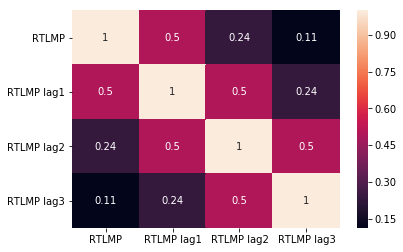

In [23]:
# time series 
df_timeseries = df[['RTLMP', ]]
df_timeseries['RTLMP lag1'] = df.RTLMP.shift(1)
df_timeseries['RTLMP lag2'] = df.RTLMP.shift(2)
df_timeseries['RTLMP lag3'] = df.RTLMP.shift(3)
sns.heatmap(df_timeseries.corr(), annot=True)
df_timeseries.corr()

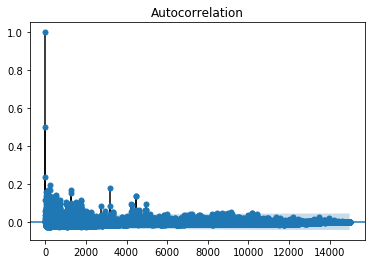

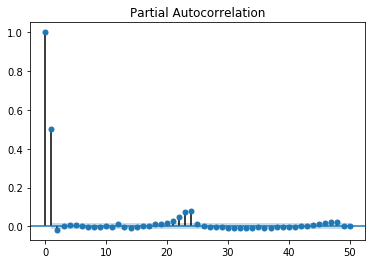

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.RTLMP); plt.show()
plot_pacf(df.RTLMP, lags=50); plt.show()

2. Predictive Model 

In [25]:
# Data Preprocessing 
file_path = "data/Assignment 3 - timeseries_data.xlsx"
df = pd.read_excel(file_path, )   
df.DATETIME = pd.to_datetime(df.DATETIME)
df.set_index('DATETIME', inplace=True, drop=True)
df.sort_index(inplace=True)
df.columns = ['RTLMP', 'WIND',
       'SOLAR', 'RTLOAD', 'HOURENDING',
       'MARKETDAY', 'PEAKTYPE', 'MONTH', 'YEAR']



# 1. outlier treatment 
df = df[(df['RTLMP']<2000) & (df['WIND'])<20000]
RTLMP = df['RTLMP']

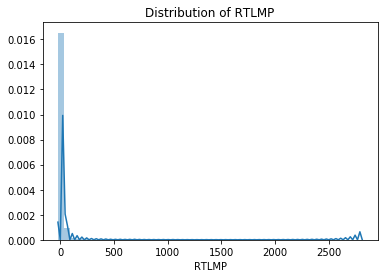

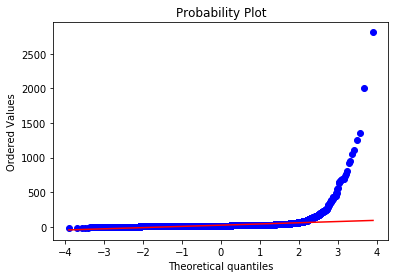

minimum of RTLMP =  -17.86


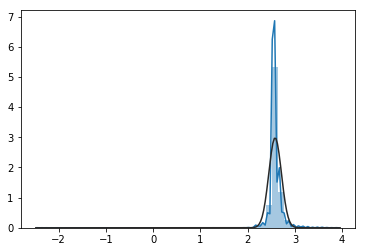

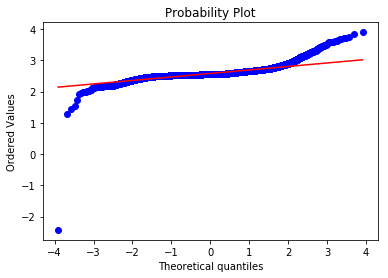

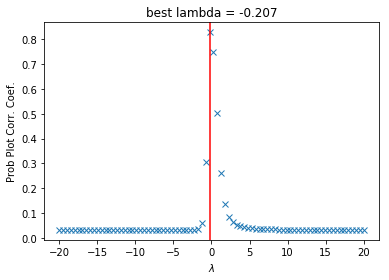

In [26]:
# 2. data transformation: box-cox transformation

# BEFORE TRANSFORMAION 
sns.distplot(RTLMP).set_title("Distribution of RTLMP"); plt.show()
res = stats.probplot(RTLMP, plot=plt); plt.show()

print("minimum of RTLMP = ", RTLMP.min())

RTLMP_transform, lmbda = stats.boxcox(RTLMP + 18)
sns.distplot(RTLMP_transform , fit=stats.norm); plt.show()
stats.probplot(RTLMP_transform, plot=plt); plt.show()

# best lambda search 
fig, ax = plt.subplots()
stats.boxcox_normplot(RTLMP + 18, -20, 20, plot=ax)
ax.axvline(lmbda, color='r'); 
ax.set_title('best lambda = '+ "{:.3f}".format(lmbda)); plt.show()

# print(stats.normaltest(RTLMP_transform)[1])

# transform inplace 
df['RTLMP'] = stats.boxcox(18 + df['RTLMP'], lmbda)

c:\program files (x86)\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Chen Yunfei\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Chen Yunfei\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


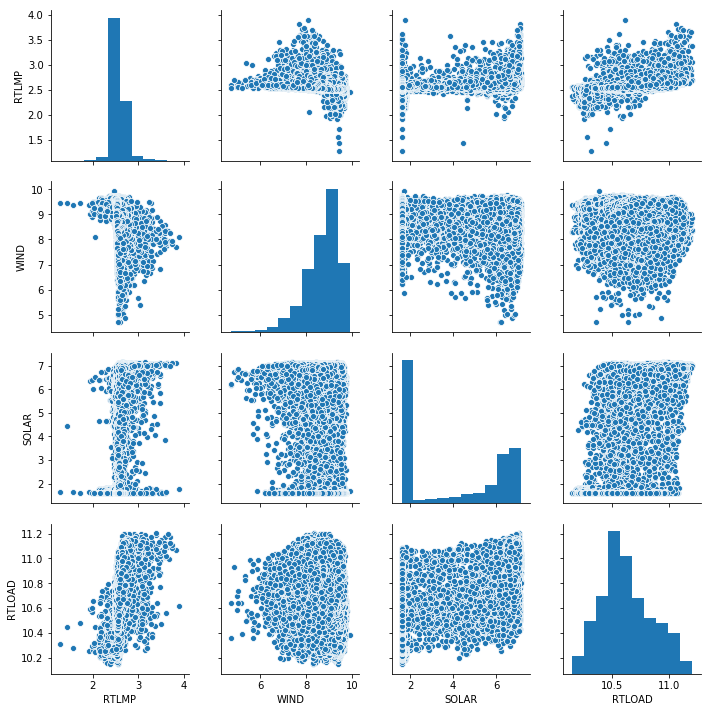

In [27]:
df['WIND'] = np.log(df['WIND'])
df['SOLAR'] = np.log(df['SOLAR'] + 5)
df['RTLOAD'] = np.log(df['RTLOAD'])

df['RTLMP current'] = df['RTLMP']
df['RTLMP previous'] = df['RTLMP'].shift(1)
df['RTLMP'] = df['RTLMP'].shift(-1)

df = df[(df.WIND>4) & (df.RTLMP>-2)]
sns.pairplot(df[['RTLMP','WIND','SOLAR','RTLOAD']], size=2.5)


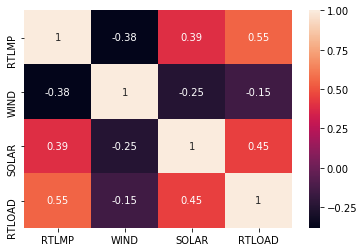

In [28]:
sns.heatmap( df[['RTLMP','WIND','SOLAR','RTLOAD']].corr(), annot=True)

In [29]:
#  forecast model
peak_dummy_WEPEAK = 1*(df.PEAKTYPE == 'WEPEAK')
peak_dummy_WEPEAK.name = "peak_dummy_WEPEAK"
peak_dummy_WDPEAK = 1*(df.PEAKTYPE == 'WDPEAK')
peak_dummy_WDPEAK.name = "peak_dummy_WDPEAK"
# if both dummies are 0, that means OFFPEAK
df_model = pd.concat([df, peak_dummy_WDPEAK, peak_dummy_WEPEAK], axis=1)


# train-test split: 8:2 
n = round(df_model.shape[0]*0.8)
df_train = df_model.iloc[:n+1, ].dropna(how='any', )
df_test = df_model.iloc[n+1: , ]

# training
explanatory_variable = ['WIND', 'SOLAR', 'RTLOAD', 'peak_dummy_WDPEAK', 'peak_dummy_WEPEAK', 'RTLMP current', 'RTLMP previous']
dependent_variable = 'RTLMP'
X = df_train[explanatory_variable]
X = sm.add_constant(X)
Y = df_train[dependent_variable]

# wls 
W = 1./np.abs(X.SOLAR)
wls_model = sm.WLS(Y, X, W).fit()
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:                  RTLMP   R-squared:                       0.575
Model:                            WLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     2318.
Date:                Tue, 17 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:03:15   Log-Likelihood:                 12862.
No. Observations:               11983   AIC:                        -2.571e+04
Df Residuals:                   11975   BIC:                        -2.565e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4804      0.04

C:\Users\Chen Yunfei\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


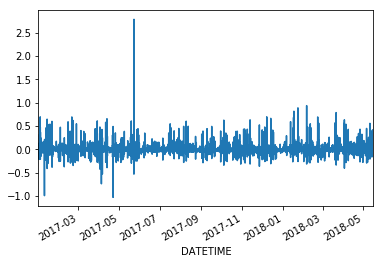

In [30]:
wls_model.resid.plot()

C:\Users\Chen Yunfei\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


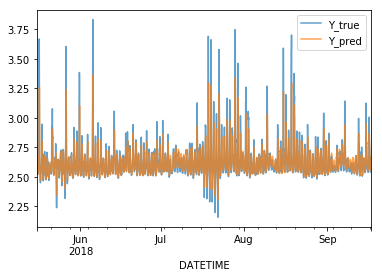

0.005569345998810876 0.036438147866687295


In [31]:
# test
X_test = df_test[explanatory_variable]
X_test = sm.add_constant(X_test)
Y_test = df_test[dependent_variable]
Y_pred = wls_model.predict(X_test)

df_testplot = pd.DataFrame()
df_testplot['Y_true'] = Y_test
df_testplot['Y_pred'] = Y_pred
df_testplot.plot(alpha=.7); plt.show() 

mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
print(mse, mae)

In [32]:
# cart tree optimized with grid search 
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

# parameters = {'max_depth':range(3,11), 'min_samples_split':range(2,11), 'min_samples_leaf':range(1,6)}

# tree_regressor = tree.DecisionTreeRegressor('mse')
# clf = GridSearchCV(tree_regressor, parameters, cv=5, verbose=0).fit(X.iloc[:,1:], Y)
# print(clf.best_estimator_.get_params())

# dump(clf, 'models/best cart.joblib') 

clf = load("models/best cart.joblib")

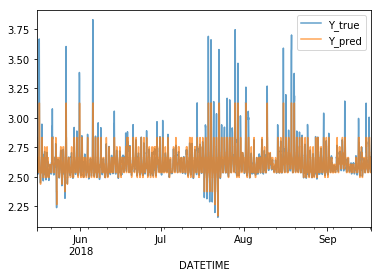

0.006323519021911595 0.04040775752140598


In [33]:

Y_pred = clf.best_estimator_.predict(X_test.iloc[:,1:])

df_testplot['Y_true'] = Y_test
df_testplot['Y_pred'] = Y_pred
df_testplot.plot(alpha=.7); plt.show() 

mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
print(mse, mae)

#### Assignment 4 - Futures

In [34]:
path_file = "data\Assignment 4 - dataset.xlsx"
df = pd.read_excel(path_file).iloc[3:]
df.set_index("Time Series Function", inplace=True)
df.sort_index(inplace=True)
df.columns = ['ERN', 'H', 'XPR']
df['ERN'] = df['ERN'].astype(np.float)
df['H'] = df['H'].astype(np.float)
df['XPR'] = df['XPR'].astype(np.float)
df.index.name = ''
display(df.head())
display(df.corr())

# def: 
# ERN:  peak hourly electricity prices of ERCOT North Hub 
# H:  Price per MMBTU of natural gas on the NYMEX of the Henry Hub
# XPR:  Price for heat rate (1./efficiency of power plant)  of ERCOT North Hub;
#       XRP = ERN / H
# contract size: 1 MW;  2500 MMBtus = 732.67778 MW·h;  50 MW/hour
# min price change: ($0.01) per MWh;  ($0.001) per MMBtu;  0.001 per MMBTU/MWh
# monthly limit: 7,143;  4,000;  

,ERN,H,XPR
,,,
2016-01-26,24.62,2.713,9.074825
2016-01-27,24.50,2.700,9.074074
2016-01-28,24.43,2.692,9.075037
2016-01-29,24.88,2.742,9.073669
2016-02-01,24.56,2.700,9.096296


,ERN,H,XPR
ERN,1.000000,0.984395,-0.738712
H,0.984395,1.000000,-0.844944
XPR,-0.738712,-0.844944,1.000000


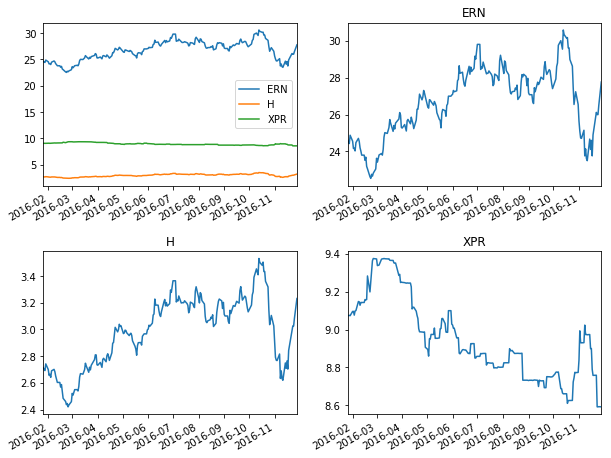

In [35]:
fig, axes = plt.subplots(2,2,figsize=(10,8,))
plt.subplots_adjust(hspace=.4, wspace=.2)
df.plot(ax=axes[0][0])
df['ERN'].plot(ax = axes[0][1], title='ERN')
df['H'].plot(ax = axes[1][0], title='H')
df['XPR'].plot(ax = axes[1][1], title='XPR')

In [36]:
# HEDGING STRATEGY & ANALYSIS 

Multiplier_XPR = 50
Multiplier_H = 2500 
N_hold = 1000
N_XPR = - N_hold / Multiplier_XPR
limit_H = 4000
N_prev = 56
Adjust_ratio = 0.99  


def get_hedging_results(N_prev, Adjust_ratio):
    df_position = pd.DataFrame().reindex_like(df)
    df_pnl = pd.DataFrame().reindex_like(df)
    df_position['ERN'] = 0
    df_position['XPR'] = N_XPR

    df_pnl['ERN'] = (df.ERN - df.ERN.shift(1) ) * N_hold
    df_pnl['XPR'] = (df.XPR - df.XPR.shift(1) ) * N_XPR *  Multiplier_XPR

    # assume hedging starts from 2016-01-27
    # find weekly dates
    all_trading_dates = df.index
    rebalancing_dates = [df.index[1], ]
    date = df.index[1]
    while date <= df.index[-1]:
        date = date + timedelta(weeks=1)
        if date not in all_trading_dates:
            if sum(all_trading_dates > date) > 0:
                date = all_trading_dates[all_trading_dates > date][0] 
                rebalancing_dates.append(date)
        else:   
            rebalancing_dates.append(date)


    # use the previous market heat rate to determine number of H contracts to enter 
    for date in rebalancing_dates:
        prev_dates = all_trading_dates[all_trading_dates < date][-N_prev:]
        prev_heat_rates = df.loc[prev_dates, 'XPR']
        prev_mean_heat_rate = prev_heat_rates.mean()
        N_H = prev_mean_heat_rate *  Multiplier_XPR * N_XPR / Multiplier_H 

        N_H *= Adjust_ratio 

        if N_H > limit_H: 
            print("monthly spot position limit exceeded!")
        df_position.loc[date, 'H'] = N_H
    df_position['H'] = df_position['H'].fillna(method='ffill')
    df_pnl['H'] = df_position['H'] * Multiplier_H * (df.H - df.H.shift(1))


    df_pnl.columns = ['PnL_Power price', 'PnL_H', 'PnL_XPR', ]
    df_pnl['PnL_Overall_withhedging'] = df_pnl.sum(axis=1)
    df_pnl['PnL_Overall_nohedging'] = df_pnl['PnL_Power price']
    df_pnl.fillna(0, inplace=True)
    # df_pnl['Nav_nohedging'] = N_hold * df['ERN']
    # df_pnl['Nav_withhedging'] = df_pnl['Nav_nohedging'] + df_pnl['PnL_Overall_withhedging']
    
    return df_pnl, df_position

In [37]:
# Optimization 1
gains = -10**3
min_std = 10**2
best_Adjust_ratio = 0.9
best_N_prev = 1 

for Adjust_ratio in np.arange(0.90, 1, 0.01):
    for N_prev in range(1, 100):
        df_pnl, df_position = get_hedging_results(N_prev, Adjust_ratio)
        if df_pnl.PnL_Overall_withhedging.sum() > gains and df_pnl.PnL_Overall_withhedging.std() < min_std:
#             gains = df_pnl.PnL_Overall_withhedging.sum() 
            min_std = df_pnl.PnL_Overall_withhedging.std()
            best_Adjust_ratio = Adjust_ratio
            best_N_prev = N_prev
print(best_Adjust_ratio, best_N_prev, gains)

# Optimization 2
gains = -10**3
min_std = 10**2
best_Adjust_ratio = 0.9
best_N_prev = 1 

for Adjust_ratio in np.arange(0.90, 1, 0.01):
    for N_prev in range(1, 100):
        df_pnl, df_position = get_hedging_results(N_prev, Adjust_ratio)
        if df_pnl.PnL_Overall_withhedging.sum() > gains and df_pnl.PnL_Overall_withhedging.std() < 70:
            gains = df_pnl.PnL_Overall_withhedging.sum() 
            best_Adjust_ratio = Adjust_ratio
            best_N_prev = N_prev
print(best_Adjust_ratio, best_N_prev, gains)

0.9500000000000001 1 -1000
0.9 56 -669.3396724413294


- losses happen when power price and gas price move in reverse directions, in this case heat rate move in the same direction with power price

In [38]:
df_pnl, df_position = get_hedging_results(56, 0.9)

# df_pnl, df_position = get_hedging_results(1, 0.95)

In [39]:
print(df_pnl.PnL_Overall_withhedging.sum())

-669.3396724413294


In [40]:
df_position.to_csv('data/Assignment 4 Result - WEEKLY REBALANCING.csv')
df_pnl.to_csv('data/Assignment 4 Result- PnL.csv')

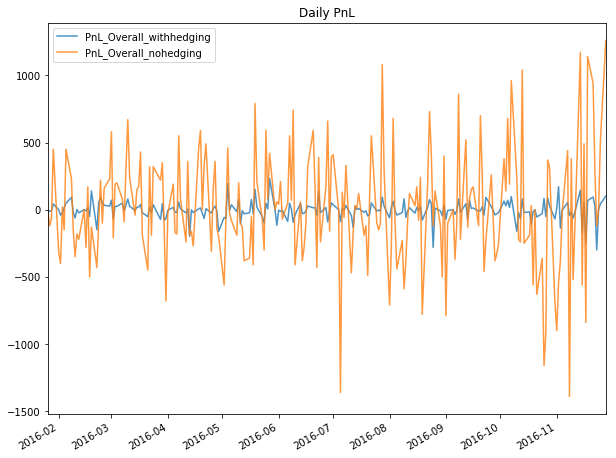

In [41]:
# PERFORMANCE EVALUATION 

df_pnl[['PnL_Overall_withhedging', 'PnL_Overall_nohedging']].plot(alpha=.8, title='Daily PnL', figsize=(10,8))
plt.savefig('plots/PnL comparison.jpg')

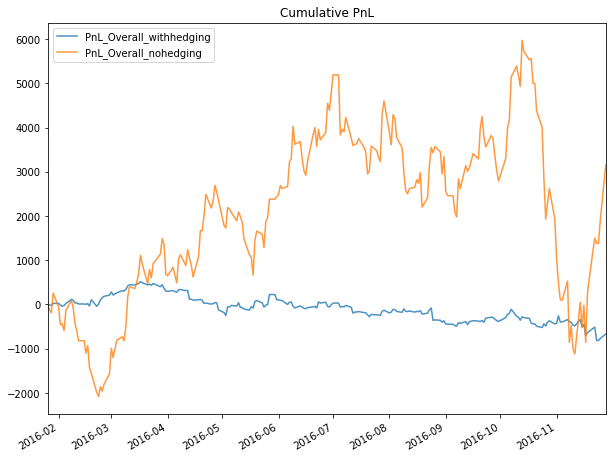

In [42]:
df_pnl[['PnL_Overall_withhedging', 'PnL_Overall_nohedging']].cumsum(axis=0).plot(alpha=.8, title='Cumulative PnL', figsize=(10,8))
plt.savefig('plots/PnL Cumulative comparison.jpg')

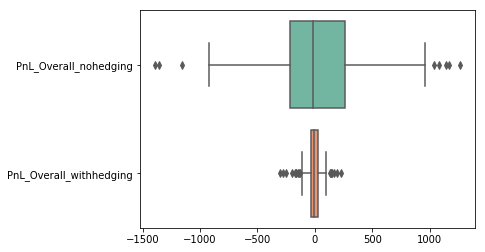

In [43]:
ax = sns.boxplot(data=df_pnl[['PnL_Overall_nohedging', 'PnL_Overall_withhedging']], orient="h", palette="Set2")
plt.savefig('plots/PnL comparison boxplot.jpg')

In [44]:
for col in ['PnL_Overall_nohedging', 'PnL_Overall_withhedging']:
    print(df_pnl[col].describe())
    print('\n')

count     219.000000
mean       14.383562
std       426.434932
min     -1390.000000
25%      -220.000000
50%       -20.000000
75%       260.000000
max      1260.000000
Name: PnL_Overall_nohedging, dtype: float64


count    219.000000
mean      -3.056346
std       68.612674
min     -300.242377
25%      -29.298189
50%       -3.493697
75%       29.533501
max      231.616862
Name: PnL_Overall_withhedging, dtype: float64




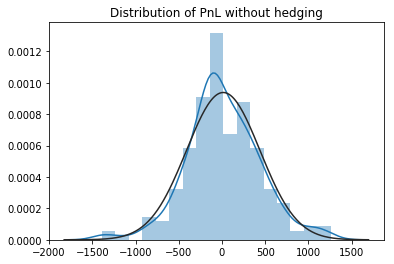

<Figure size 432x288 with 0 Axes>

In [45]:
sns.distplot(df_pnl[['PnL_Overall_nohedging']] , fit=stats.norm).set_title('Distribution of PnL without hedging'); plt.show()
plt.savefig('plots/Probability Distribution of PnL without hedging')

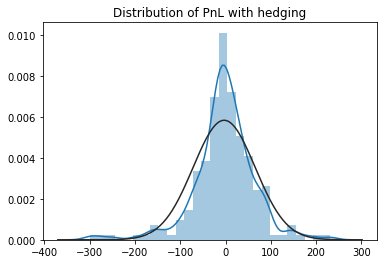

<Figure size 432x288 with 0 Axes>

In [46]:
sns.distplot(df_pnl[['PnL_Overall_withhedging']] , fit=stats.norm).set_title('Distribution of PnL with hedging'); plt.show()
plt.savefig('plots/Probability Distribution of PnL with hedging')